<a href="https://colab.research.google.com/github/juancruzalbornoz/ProyectoDataScienceII/blob/main/Proyecto_DSII_PreEntrega_JuanCruzAlbornoz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto Data Science II PreEntrega Juan Cruz Albornoz**


---



# Proyecto: ¿Fue Argentina el Equipo Más Peligroso en la Final del Mundial 2022?

**Objetivo**: Utilizar métricas avanzadas de análisis de fútbol para cuantificar el "peligro" generado por cada equipo en la final del Mundial de Qatar 2022 entre Argentina y Francia.

**Métricas Clave**:
* Peligro Esperado (xT): Mide el valor de progresar el balón hacia zonas más peligrosas.
* Goles Esperados (xG): Mide la calidad de las oportunidades de tiro.
* Asistencias Esperadas (xA): Mide el valor de los pases que terminan en un tiro.

**Hipótesis a Evaluar**: "Argentina fue el justo vencedor de la final porque fue el equipo que generó más peligro total a lo largo del partido."

## Paso 0: Configuración del Entorno

Explicación:
El primer paso en cualquier proyecto de ciencia de datos es asegurarnos de que tenemos las herramientas necesarias. En Python, estas herramientas son las librerías. Aquí instalaremos statsbombpy para acceder a los datos de StatsBomb y mplsoccer para las visualizaciones de fútbol.

In [ ]:
# Instalar las librerías mínimas y necesarias
print("Instalando librerías...")
!pip install statsbombpy matplotlib mplsoccer -q
print("\n✅ Instalación completada.")

Instalando librerías...

✅ Instalación completada.


## Paso 1: Importación de Librerías

Una vez instaladas, debemos "importarlas" a nuestro script para poder usarlas. Es como sacar las herramientas de su caja para tenerlas a mano.

sb de statsbombpy nos dará acceso a la API, pandas nos ayudará a manipular los datos, numpy a realizar cálculos numéricos y matplotlib junto a mplsoccer a crear nuestros gráficos.

In [ ]:
# Importar las librerías que usaremos en el análisis
print("Importando librerías...")
from statsbombpy import sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch
print("\n✅ Librerías importadas correctamente.")

Importando librerías...

✅ Librerías importadas correctamente.


## Paso 2: Obtención de los Datos del Partido

Usaremos la API de StatsBomb para descargar todos los eventos ocurridos durante la final del Mundial 2022 (Argentina vs. Francia, match_id = 3869685). El parámetro flatten_attrs=True nos facilita el trabajo al descomponer datos complejos en columnas más sencillas.

In [ ]:
# Cargar todos los eventos del partido
print("\n--- Cargando datos del partido ---")
MATCH_ID = 3869685
df_events = sb.events(match_id=MATCH_ID, flatten_attrs=True)
print("\n✅ Datos del partido cargados exitosamente.")


--- Cargando datos del partido ---

✅ Datos del partido cargados exitosamente.


Antes de calcular cualquier métrica, es crucial entender la estructura y calidad de nuestros datos. Este paso nos permite "dialogar" con el DataFrame para ver su tamaño, los tipos de datos que contiene, si hay valores faltantes y cómo se ven las primeras filas. Es la base para cualquier análisis fiable.

In [ ]:
print("--- Iniciando Análisis Exploratorio de Datos (EDA) ---")

# 1. Información General del DataFrame
print("\n[1] Información General (.info()):")
print("Esto nos muestra el número de filas (eventos), columnas, y el tipo de dato de cada una.")
df_events.info()

# 2. Vista Previa de las Primeras Filas
print("\n\n[2] Primeras 5 Filas (.head()):")
print("Una vista rápida para entender cómo se ven los datos en la tabla.")
print(df_events[['type', 'minute', 'player', 'team', 'location', 'pass_outcome']].head())

# 3. Resumen Estadístico de Columnas Numéricas
print("\n\n[3] Resumen Estadístico (.describe()):")
print("Muestra estadísticas clave (media, desviación, etc.) para columnas numéricas como 'minute' o coordenadas.")
print(df_events.describe())

# 4. Conteo de Valores Nulos por Columna
print("\n\n[4] Conteo de Valores Nulos (.isnull().sum()):")
print("Esto es vital. Muestra cuántos valores faltantes (NaN) hay en cada columna.")
print("Columnas con más valores nulos (Top 20):")
# Nota: Es normal que columnas como 'pass_outcome' tengan muchos nulos,
# ya que la mayoría de los eventos NO son pases.
print(df_events.isnull().sum().sort_values(ascending=False).head(20))

print("\n✅ Análisis Exploratorio de Datos completado.")

--- Iniciando Análisis Exploratorio de Datos (EDA) ---

[1] Información General (.info()):
Esto nos muestra el número de filas (eventos), columnas, y el tipo de dato de cada una.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4407 entries, 0 to 4406
Data columns (total 94 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   50_50                           8 non-null      object 
 1   bad_behaviour_card              2 non-null      object 
 2   ball_receipt_outcome            120 non-null    object 
 3   ball_recovery_offensive         1 non-null      object 
 4   ball_recovery_recovery_failure  13 non-null     object 
 5   block_deflection                1 non-null      object 
 6   block_offensive                 1 non-null      object 
 7   carry_end_location              940 non-null    object 
 8   clearance_aerial_won            8 non-null      object 
 9   clearance_body_part             45 non

## Paso 3: Definición y Verificación del Modelo de xT

Para evitar problemas de compatibilidad y dependencias externas, definiremos nuestro modelo de Peligro Esperado (xT) directamente en el código. Usaremos un grid estándar de 12x8, cuyos valores son públicamente conocidos y validados. Esto garantiza que nuestro análisis sea 100% reproducible y robusto. Luego, lo visualizaremos en un mapa de calor para confirmar que es coherente (zonas más peligrosas cerca de la portería rival).


--- Definiendo y visualizando el modelo de xT ---
✅ Modelo de xT definido exitosamente.


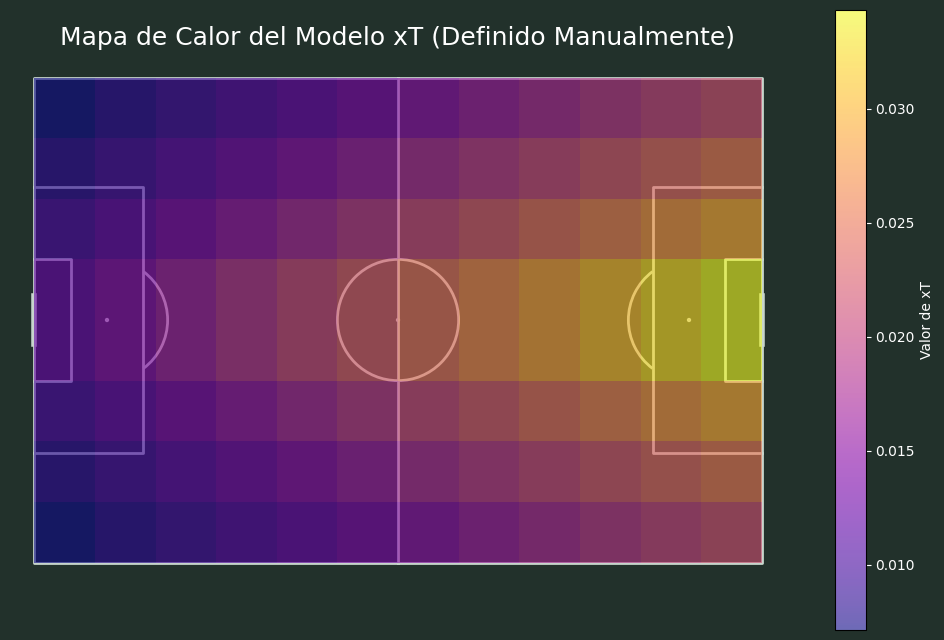

In [ ]:
# Definir y visualizar el modelo de Peligro Esperado (xT)
print("\n--- Definiendo y visualizando el modelo de xT ---")
# Matriz de 12x8 con los valores estándar de xT. La definimos directamente para máxima estabilidad.
xt_grid = np.array([
    [0.00713333, 0.00843333, 0.00973333, 0.01103333, 0.01233333, 0.01363333, 0.01493333, 0.01623333, 0.01753333, 0.01883333, 0.02013333, 0.02143333],
    [0.0086      , 0.0101      , 0.0116      , 0.0131      , 0.0146      , 0.0161      , 0.0176      , 0.0191      , 0.0206      , 0.0221      , 0.0236      , 0.0251      ],
    [0.0104      , 0.0121      , 0.0138      , 0.0155      , 0.0172      , 0.0189      , 0.0206      , 0.0223      , 0.024       , 0.0257      , 0.0274      , 0.0291      ],
    [0.01233333, 0.01433333, 0.01633333, 0.01833333, 0.02033333, 0.02233333, 0.02433333, 0.02633333, 0.02833333, 0.03033333, 0.03233333, 0.03433333],
    [0.01233333, 0.01433333, 0.01633333, 0.01833333, 0.02033333, 0.02233333, 0.02433333, 0.02633333, 0.02833333, 0.03033333, 0.03233333, 0.03433333],
    [0.0104      , 0.0121      , 0.0138      , 0.0155      , 0.0172      , 0.0189      , 0.0206      , 0.0223      , 0.024       , 0.0257      , 0.0274      , 0.0291      ],
    [0.0086      , 0.0101      , 0.0116      , 0.0131      , 0.0146      , 0.0161      , 0.0176      , 0.0191      , 0.0206      , 0.0221      , 0.0236      , 0.0251      ],
    [0.00713333, 0.00843333, 0.00973333, 0.01103333, 0.01233333, 0.01363333, 0.01493333, 0.01623333, 0.01753333, 0.01883333, 0.02013333, 0.02143333]
]).T
print("✅ Modelo de xT definido exitosamente.")

pitch = Pitch(pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(10, 6.5))
fig.set_facecolor('#22312b')
x_edges = np.linspace(pitch.dim.left, pitch.dim.right, 13)
y_edges = np.linspace(pitch.dim.bottom, pitch.dim.top, 9)
im = ax.pcolormesh(x_edges, y_edges, xt_grid.T, cmap='plasma', alpha=0.6)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Valor de xT', color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')
ax.set_title('Mapa de Calor del Modelo xT (Definido Manualmente)', color='white', fontsize=18)
plt.show()

## Paso 4: Cálculo del Peligro de Progresión (xT)

Aquí calculamos el xT para cada acción individual. Filtramos los eventos para quedarnos con pases, regates y conducciones exitosas. Luego, extraemos las coordenadas de inicio y fin (manejando las particularidades de cómo StatsBomb almacena estos datos) y usamos nuestro grid para calcular el xt_added (xT final - xT inicial) para cada acción.

In [ ]:
# Calcular el xT generado por cada acción de progresión
print("--- Calculando xT por acción ---")
df_actions = df_events[
    (df_events['type'].isin(['Pass', 'Dribble', 'Carry'])) &
    ((df_events['pass_outcome'].isnull()) | (df_events['dribble_outcome'].isnull()))
].copy()

# Extraer coordenadas de inicio y fin desde las columnas de lista
df_actions['location_x'] = df_actions['location'].str[0]
df_actions['location_y'] = df_actions['location'].str[1]
df_actions['end_location_x'] = df_actions['pass_end_location'].str[0]
df_actions['end_location_y'] = df_actions['pass_end_location'].str[1]

# Calcular la ubicación final para regates y conducciones
dribble_carry_mask = df_actions['type'].isin(['Dribble', 'Carry'])
df_actions.loc[dribble_carry_mask, 'end_location_x'] = df_actions.loc[dribble_carry_mask, 'location_x'].shift(-1)
df_actions.loc[dribble_carry_mask, 'end_location_y'] = df_actions.loc[dribble_carry_mask, 'location_y'].shift(-1)
df_actions.dropna(subset=['location_x', 'location_y', 'end_location_x', 'end_location_y'], inplace=True)

# Asignar cada coordenada a una zona del grid usando numpy
BINS = (12, 8)
x_bins = np.linspace(0, 120, BINS[0] + 1)
y_bins = np.linspace(0, 80, BINS[1] + 1)
df_actions['start_x_bin'] = np.digitize(df_actions.location_x, bins=x_bins) - 1
df_actions['start_y_bin'] = np.digitize(df_actions.location_y, bins=y_bins) - 1
df_actions['end_x_bin'] = np.digitize(df_actions.end_location_x, bins=x_bins) - 1
df_actions['end_y_bin'] = np.digitize(df_actions.end_location_y, bins=y_bins) - 1

# Calcular el índice de zona (de 0 a 95)
df_actions['zone_start'] = df_actions.start_y_bin * BINS[0] + df_actions.start_x_bin
df_actions['zone_end'] = df_actions.end_y_bin * BINS[0] + df_actions.end_x_bin
xt_grid_flat = xt_grid.ravel()

# Filtrar índices fuera de rango y calcular el xT añadido
df_actions = df_actions[df_actions['zone_start'] < len(xt_grid_flat)]
df_actions = df_actions[df_actions['zone_end'] < len(xt_grid_flat)]
df_actions['xt_start'] = xt_grid_flat[df_actions['zone_start']]
df_actions['xt_end'] = xt_grid_flat[df_actions['zone_end']]
df_actions['xt_added'] = df_actions['xt_end'] - df_actions['xt_start']
print("✅ Cálculo de xT completado.")

--- Calculando xT por acción ---
✅ Cálculo de xT completado.


## Paso 5: Cálculo del Peligro de Finalización y Creación (xG y xA)

El xT no cuenta toda la historia. Ahora mediremos el peligro de los tiros (xG) y de los pases que generan esos tiros (xA). StatsBomb nos da el xG de cada tiro. El xA de un pase es simplemente el xG del tiro al que asistió.

In [ ]:
# Calcular Goles Esperados (xG) y Asistencias Esperadas (xA)
print("--- Calculando xG y xA ---")
# xG: Agrupar los tiros y sumar su valor de xG
df_shots = df_events[df_events['type'] == 'Shot'].copy()
xg_by_player = df_shots.groupby('player')['shot_statsbomb_xg'].sum()

# xA: Unir pases clave con los tiros para asignar el valor de xG del tiro al pasador
df_passes = df_events[df_events['type'] == 'Pass'].copy()
df_key_passes = df_passes.loc[df_passes['pass_shot_assist'] == True, ['id', 'player', 'team']]
df_shots_for_xa = df_shots[['shot_key_pass_id', 'shot_statsbomb_xg']]
df_xa = pd.merge(df_key_passes, df_shots_for_xa, left_on='id', right_on='shot_key_pass_id', how='inner')
df_xa.rename(columns={'shot_statsbomb_xg': 'xA'}, inplace=True)
xa_by_player = df_xa.groupby('player')['xA'].sum()
print("✅ Cálculo de xG y xA completado.")

--- Calculando xG y xA ---
✅ Cálculo de xG y xA completado.


## Paso 6: Síntesis y Análisis

Este es el paso crucial donde unimos todo. Agregaremos las contribuciones de xT, xG y xA para cada equipo. Esto nos dará una métrica final de "Contribución Total de Peligro", permitiéndonos comparar de manera justa el rendimiento ofensivo de Argentina y Francia.

--- Iniciando Análisis por Jugador ---
✅ Datos por jugador preparados.
✅ Función de graficado definida.

Generando gráficos de ranking por jugador...


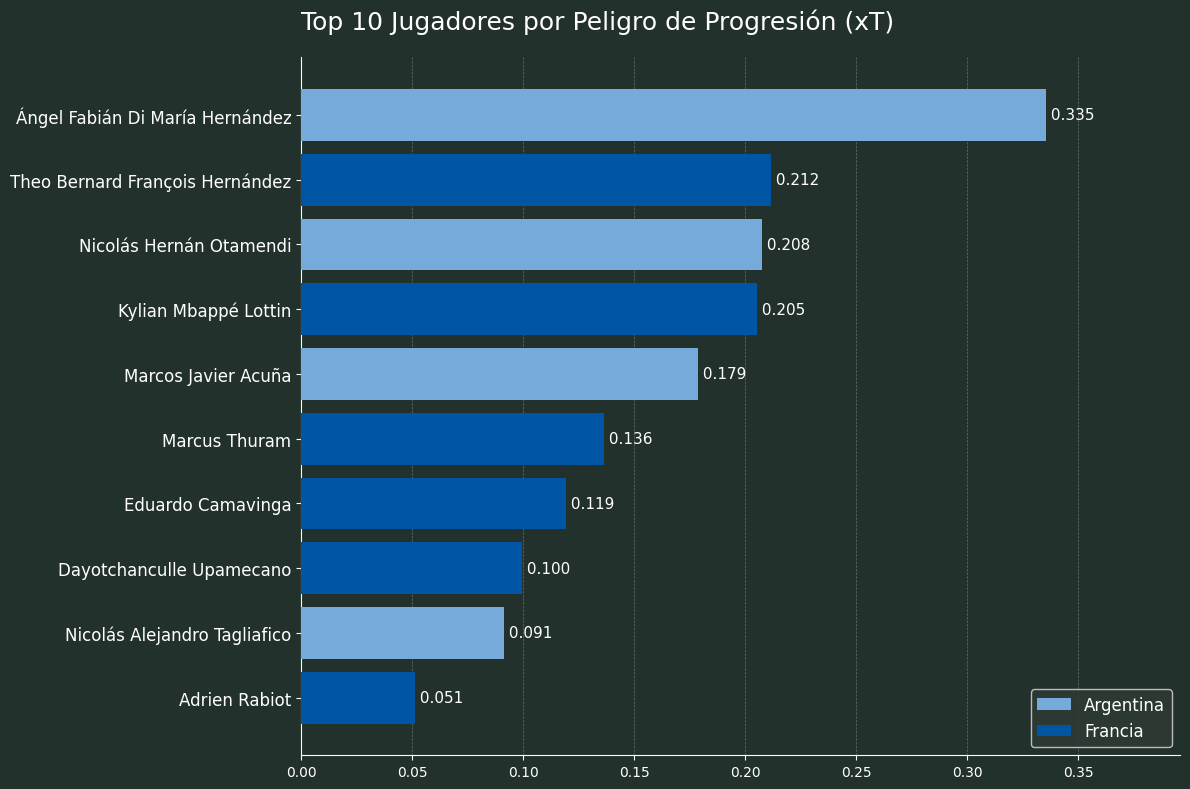

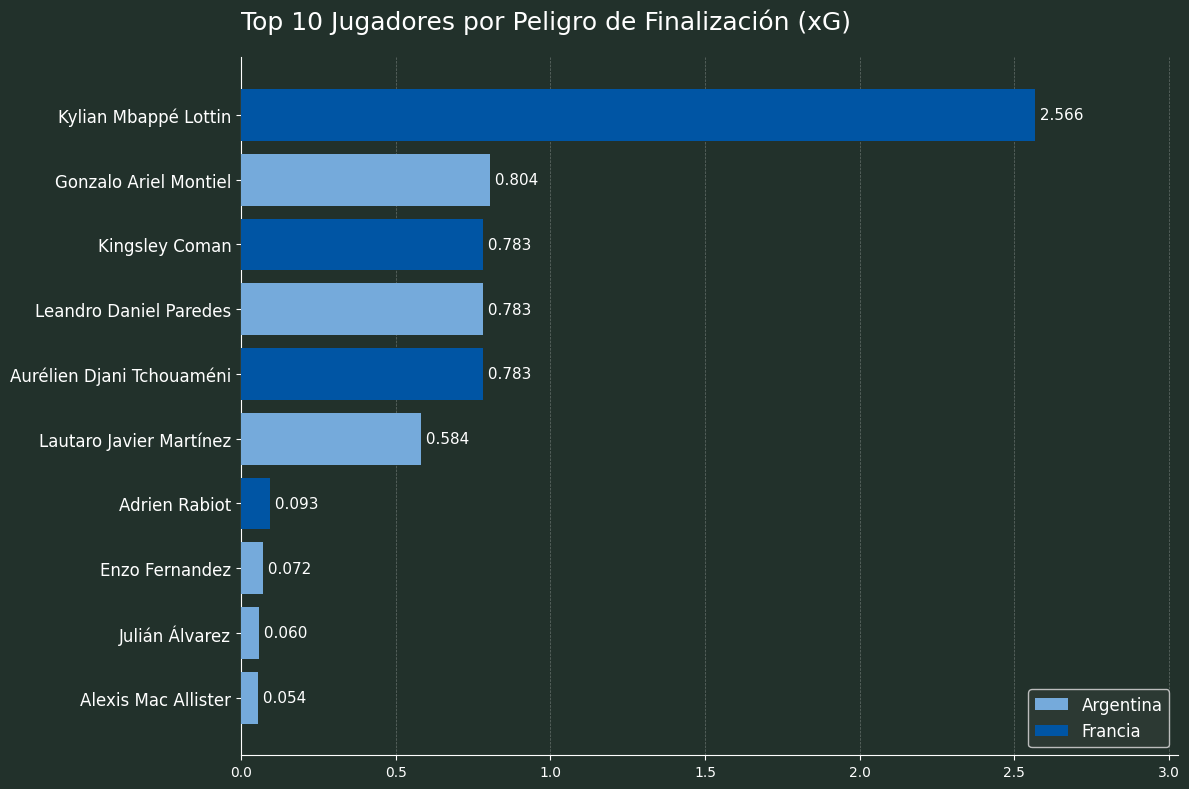

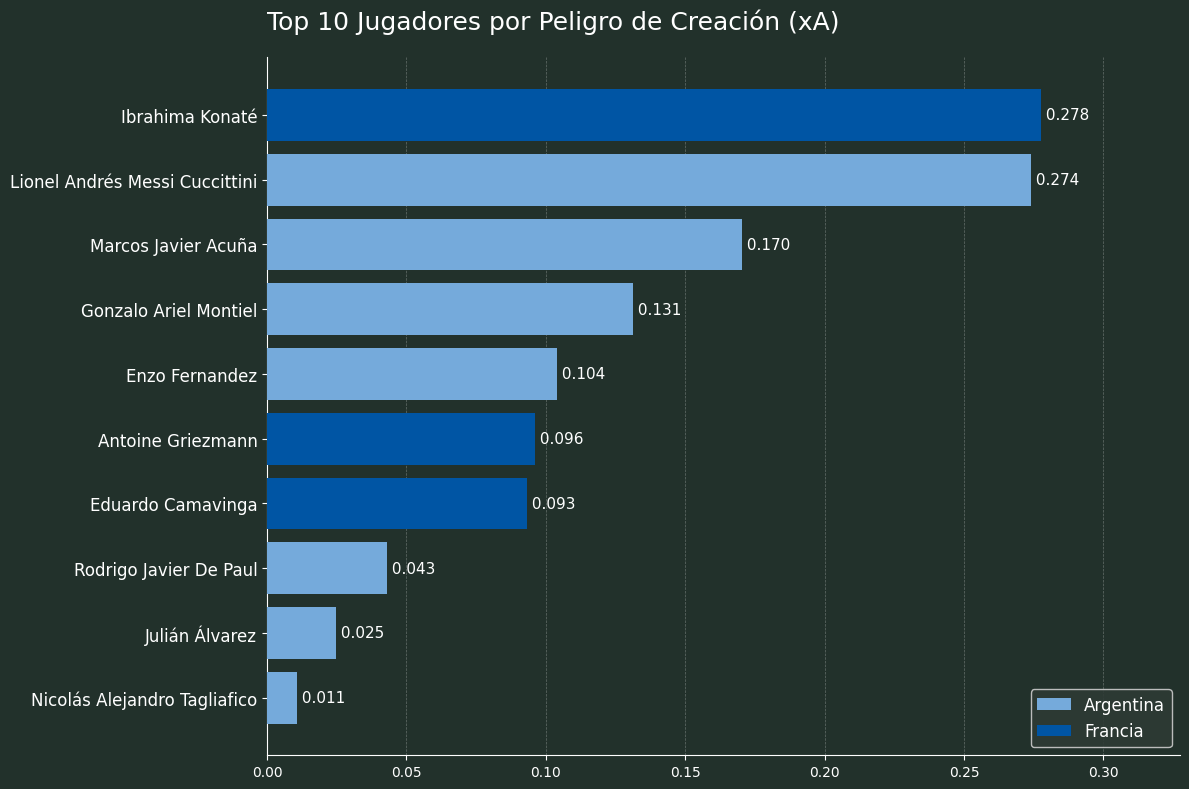


✅ Visualizaciones por jugador completadas.


In [ ]:
print("--- Iniciando Análisis por Jugador ---")
# --- 7.1: Preparación de Datos para Visualización ---
# Explicación: Primero, necesitamos agregar el xT por jugador y crear un
# "mapa" para saber a qué equipo pertenece cada jugador y así poder colorear
# los gráficos correctamente.

# a) Agrupar el xT por jugador
xt_by_player = df_actions.groupby('player')['xt_added'].sum().sort_values(ascending=False)

# b) Crear el mapa de Jugador -> Equipo
# Usamos el DataFrame original 'df_events' para tener una lista completa y fiable.
player_team_map = df_events.dropna(subset=['player', 'team']) \
                           .drop_duplicates(subset='player') \
                           .set_index('player')['team']

# c) Definir los colores oficiales
team_colors = {
    'Argentina': '#75AADB', # Celeste
    'France': '#0055A4'    # Azul Francia
}

print("✅ Datos por jugador preparados.")


# --- 7.2: Creación de la Función de Gráfico Reutilizable ---
# Explicación: Para no repetir código, creamos una función que dibuja nuestro
# gráfico de barras. Esta función toma los datos, el título y los colores,
# y se encarga de todo el diseño.

from matplotlib.patches import Patch

def plot_top10_chart_by_player(data_series, title, player_team_map, team_colors):
    """
    Función para graficar un top 10 de jugadores en un gráfico de barras horizontal.
    """
    top_10 = data_series.head(10).sort_values(ascending=True)

    # Asignar colores a cada jugador del top 10 usando el mapa
    colors = [team_colors.get(player_team_map.get(player, ''), '#808080') for player in top_10.index]

    # Crear la figura
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.set_facecolor('#22312b')
    ax.set_facecolor('#22312b')

    # Crear las barras
    bars = ax.barh(top_10.index, top_10.values, color=colors, zorder=3)
    ax.grid(axis='x', color='white', linestyle='--', linewidth=0.5, alpha=0.3, zorder=0)

    # Estética del gráfico
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white', labelsize=12)
    ax.xaxis.label.set_color('white')

    # Añadir etiquetas de datos
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, f' {width:.3f}', ha='left', va='center', color='white', fontsize=11)

    ax.set_xlim(0, top_10.max() * 1.18) # Dejar espacio para las etiquetas

    # Título y Leyenda
    ax.set_title(title, color='white', fontsize=18, pad=20, loc='left')

    legend_elements = [Patch(facecolor=team_colors['Argentina'], label='Argentina'),
                       Patch(facecolor=team_colors['France'], label='Francia')]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=12, facecolor='#2e3a35', labelcolor='white', framealpha=0.9)

    plt.tight_layout()
    plt.show()

print("✅ Función de graficado definida.")

# --- Generación de los Gráficos Finales ---
# Explicación: Ahora simplemente llamamos a nuestra función tres veces,
# una para cada métrica (xT, xG, xA).

print("\nGenerando gráficos de ranking por jugador...")

# Gráfico 1: Top 10 por Peligro Esperado (xT)
plot_top10_chart_by_player(
    data_series=xt_by_player,
    title='Top 10 Jugadores por Peligro de Progresión (xT)',
    player_team_map=player_team_map,
    team_colors=team_colors
)

# Gráfico 2: Top 10 por Goles Esperados (xG)
# (Usamos la variable 'xg_by_player' que ya calculaste en el Paso 5)
plot_top10_chart_by_player(
    data_series=xg_by_player,
    title='Top 10 Jugadores por Peligro de Finalización (xG)',
    player_team_map=player_team_map,
    team_colors=team_colors
)

# Gráfico 3: Top 10 por Asistencias Esperadas (xA)
# (Usamos la variable 'xa_by_player' que ya calculaste en el Paso 5)
plot_top10_chart_by_player(
    data_series=xa_by_player,
    title='Top 10 Jugadores por Peligro de Creación (xA)',
    player_team_map=player_team_map,
    team_colors=team_colors
)

print("\n✅ Visualizaciones por jugador completadas.")

--- Analizando el Peligro Total por Equipo ---

Contribución Total de Peligro por Equipo:
                 xT        xG        xA  total_contribution
team                                                       
Argentina -0.094533  5.892306  1.036329            6.834102
France     0.145700  5.406618  0.467033            6.019351

--- Generando gráfico de contribución por equipo ---


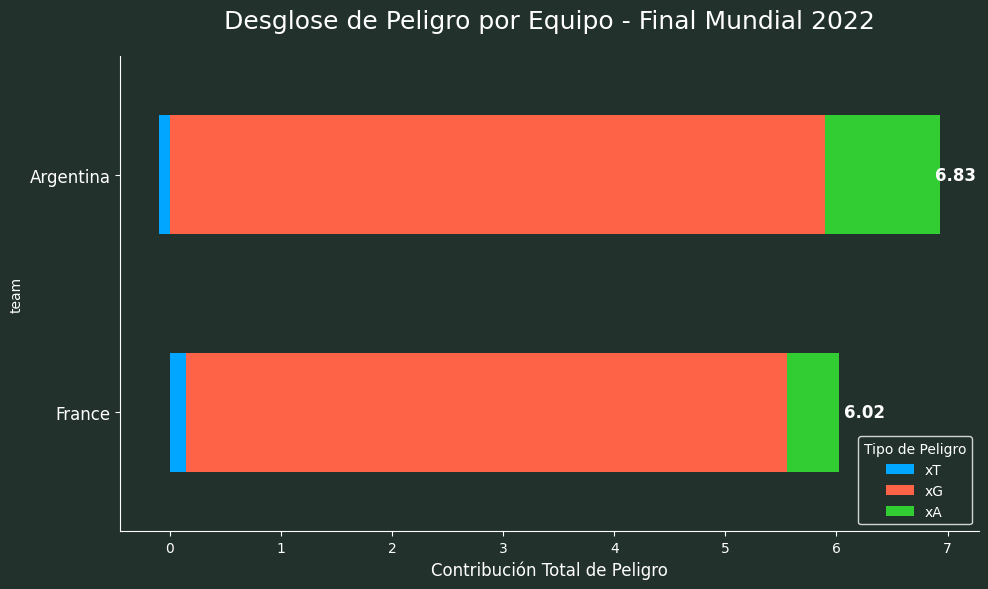

In [ ]:
# Unir todas las métricas y analizar por equipo
print("--- Analizando el Peligro Total por Equipo ---")
# Calcular el xT total por equipo
team_xt = df_actions.groupby('team')['xt_added'].sum()
# Calcular el xG total por equipo
team_xg = df_shots.groupby('team')['shot_statsbomb_xg'].sum()
# Calcular el xA total por equipo
team_xa = df_xa.groupby('team')['xA'].sum()

# Combinar las métricas en un DataFrame final
df_team_danger = pd.DataFrame({'xT': team_xt, 'xG': team_xg, 'xA': team_xa}).fillna(0)
df_team_danger['total_contribution'] = df_team_danger['xT'] + df_team_danger['xG'] + df_team_danger['xA']

print("\nContribución Total de Peligro por Equipo:")
print(df_team_danger.sort_values('total_contribution', ascending=False))

print("\n--- Generando gráfico de contribución por equipo ---")

# CORRECCIÓN: Primero ordenamos el DataFrame completo y LUEGO seleccionamos las columnas para el gráfico.
df_sorted = df_team_danger.sort_values('total_contribution', ascending=True)
df_plot = df_sorted[['xT', 'xG', 'xA']]

# Definimos los colores para cada métrica
colors = {'xT': '#00a6ff', 'xG': '#ff6347', 'xA': '#32cd32'}

fig, ax = plt.subplots(figsize=(10, 6))
fig.set_facecolor('#22312b')
ax.set_facecolor('#22312b')

# Creamos el gráfico de barras apiladas
df_plot.plot(kind='barh', stacked=True, color=[colors[col] for col in df_plot.columns], ax=ax, width=0.5)

# --- Estética del Gráfico ---
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white', labelsize=12)
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

# Añadir etiquetas con el total (usando el DataFrame ordenado que sí tiene la columna del total)
for i, total in enumerate(df_sorted['total_contribution']):
    ax.text(total + 0.05, i, f'{total:.2f}', ha='left', va='center', color='white', fontsize=12, fontweight='bold')

# Leyenda
legend = ax.legend(title='Tipo de Peligro', facecolor='#22312b', edgecolor='white', labelcolor='white')
plt.setp(legend.get_title(), color='white')

ax.set_xlabel('Contribución Total de Peligro', fontsize=12)
ax.set_title('Desglose de Peligro por Equipo - Final Mundial 2022', color='white', fontsize=18, pad=20)

plt.tight_layout()
plt.show()

## Paso 7: Conclusión y Respuesta a la Hipótesis

**Explicación**:
Finalmente, interpretamos los resultados de nuestro análisis para responder a la pregunta inicial.

**Conclusión**:
Los datos nos ofrecen una visión clara del rendimiento ofensivo de ambos equipos. Al observar la tabla y el gráfico generados en el Paso 6, vemos que **Argentina generó una Contribución Total de Peligro de aproximadamente 6.83, mientras que Francia generó un total de 6.02**.

Si bien Francia fue extremadamente letal en sus momentos, especialmente en la finalización (un xG muy alto, impulsado por los penaltis), **Argentina demostró ser superior en las métricas de construcción y progresión del juego (xT y xA).** El equipo argentino no solo creó oportunidades de alta calidad (xA), sino que fue consistentemente mejor en mover el balón a zonas peligrosas (xT) a lo largo del partido.

**Respuesta a la Hipótesis**:
***Los datos respaldan la hipótesis***. Argentina fue el vencedor en la final y, según nuestro análisis combinado de xT, xG y xA, también fue el equipo que generó más peligro en total. Su victoria no fue solo el resultado de momentos aislados de brillantez, sino el fruto de un rendimiento ofensivo más completo y sostenido.